# Plan (end of 2022)
- Other parameters: Sextapole, rf power. Finally oven parameters. 

    Should be able to just add them. Need the scaling function for new variables. 

- Guide the optimization.

    ```
    optimizer.probe(params)
    ```

- Avoid **danger zone** by monitoring the heater power.

    > x-ray -> temp of heliem -> amount of gas -> pressure -> ice -> liquid heliem heater power (final diagnosis of x-ray). We really want to avoid x-rays

    Add heater power to `venus.monitor()` and implement `venus.get_heater_power()`
    ```python
    def black_box_function(A, B, C):
        venus.set_mag_currents(A, B, C)
        ...
        while time.time() < t_end:
            venus.monitor(t_start,t_program_start,writefile,readvars,writefilefull)
            if venus.get_heater_power() > threshold:
                #TODO: reset the parameters
                return - xray_cost
        ...

        #Monitor while measuring the beam current
        return v_mean - instability_cost
    ```

- Consider "momentum". Early ending. 

    > Bias disk is fastest. Solonoid has induction. Gas pressure. 

    Modify the accquisition function of Bayes Optimization.

    ```python
    def _ucb(x, gp, kappa):
        ...
        return mean + kappa * std
    ```

    ```python
    def _ucb(x, gp, kappa):
        ...
        return mean + kappa * std - np.dot(epsilon, displacement)
        # epsilon and displacement are dim-d vectors in the parameter space
    ```

    simulate:
    assume t1 = d * c1
    inj 30s/uA
    ext 20s/uA
    mid 10s/uA

    


# 2023.1.6 

### Taking varying cost into account in Bayes Optimization
- Expected Improvement (EI) is more commonly used than Upper Confidence Bound (UCB) as an acquisition function and has some theortical basis for convergence [Vazquez et al., 2010](https://www.sciencedirect.com/science/article/pii/S0378375810001850). 
    $$EI(x)=\mathbb{E} [max(f(x)−f(x_+),0) ]$$
    where $f$ is the model, $x_+$ is the current best parameter. 
    
    Sometimes a term is added to facilitate exploration:
    $$EI(x)=\mathbb{E} [max(f(x)−f(x_+)-\xi,0) ]$$
    [Krasser, 2018](http://krasserm.github.io/2018/03/21/bayesian-optimization/#:~:text=A%20recommended%20default,.) recommended $\xi$ to be 0.01 but this seems arbitrary to me and other papers have been using $\xi=0$ so we could ignore this term for now. 
- Expected Improvement Per Unit cost [Snoek et al., 2012](https://papers.nips.cc/paper/2012/file/05311655a15b75fab86956663e1819cd-Paper.pdf)
    $$EIpu(x) = \frac{EI(x)}{c(x)}$$
    
- The problem with EIPU in the context of ML is that model training cost $c$ is fixed so it doesn't necessarilly converge to the best parameters. [Lee et al., 2020](https://assets.amazon.science/53/43/5121e84a45c7965cfd0644d81ec1/cost-aware-bayesian-optimization.pdf) proposed adding a **cost-cooled optimization phase** 
    
    However, in our case, $EIpu(x_{i+1})$ is going to change based on where we probed last. A better way to write it is $EIpu(x_{i+1};x_i)$
    
    It is also meaningful (the expected amount of improvement per unit time spent) and is a great indicator for terminating the search. 

### Initial Probing
- Draw 4 random points $\mathcal{N}(0, I_d)$ around the best parameters found last time. 


### Coding notes:

- Finished changing acquisition function from UCB to EI and tested. Performance increased slightly (about 0.5%). 
- Fixed bug in parameter ordering

### Meeting notes:
- Use h5 files with better data. Can be found on google drive. 

## Meeting Notes 2023.1.13

Milestone: 6 parameters

Data from Damon

Start writting the paper without the milestone

## Literature Search 2023.1.19

We can make some graphs like the ones used in [Toward Machine Learning Optimization of Experimental Design](https://www.tandfonline.com/doi/full/10.1080/10619127.2021.1881364?casa_token=Acw7p8D6GgwAAAAA%3A8JegBh69OQFyzndVx3Iy53wLvwStcm-9R9yXjBYyY137RKNaAfAcc_SBXVYySnpTyRLiTqfycu4f6mU)

"Cold atom experiments are increasingly complex and time consuming to optimize" [Evolutionary optimization of an experimental apparatus](https://aip.scitation.org/doi/full/10.1063/1.4808213?casa_token=2liBRG6XON0AAAAA%3A3Ab3NaXaHUvtBJALYJXjjqyXFznSKmcKhDzRbTiQP5kD4PzI8HO7TwiPOxzWNa3SOsvXu2au3_yjtw). The first few sentence in this abstract is basically our motivation for doing this project. BUT their algorithm (DE) is vastly less sample efficient.

[Fast machine-learning online optimization of ultra-cold-atom experiments](https://www.nature.com/articles/srep25890?ref=https://githubhelp.com) Nature Scientific Reports 2016. Similar to our approach, but used some weird hypothesis testing ideas. 







- Finished acquisition change in the library and pull-requested
- Finished literature search
- Started writing the paper
- Settling time:  
 qualitatively, it looks like there is no clear relation between $\delta$ and settlement time in most parameters except the coils?

## TODO 2023.2.10
Compare to Random, EI, EIPU. Time it cost to reach 10% of best

# 2023.2.17 Notes

- Finished EIpu Script with cost model

### How to implement early termination?
In Literature: 
- Bayesian Optimial Stopping (BOS) [Dai et al., 2019](https://proceedings.mlr.press/v97/dai19a.html). Used a GP with prior bias towards exponential decaying training loss as model for the epoch losses. Early terminates and use the posterior to feed into BO. Too complicated.

Method1: 
- Fit the result with an exponential model. Terminates when predicted result have 90% probability to be 10% lower than the current best beam current. 
- Problem: as we can see in this image, the beam current is more linear than exponential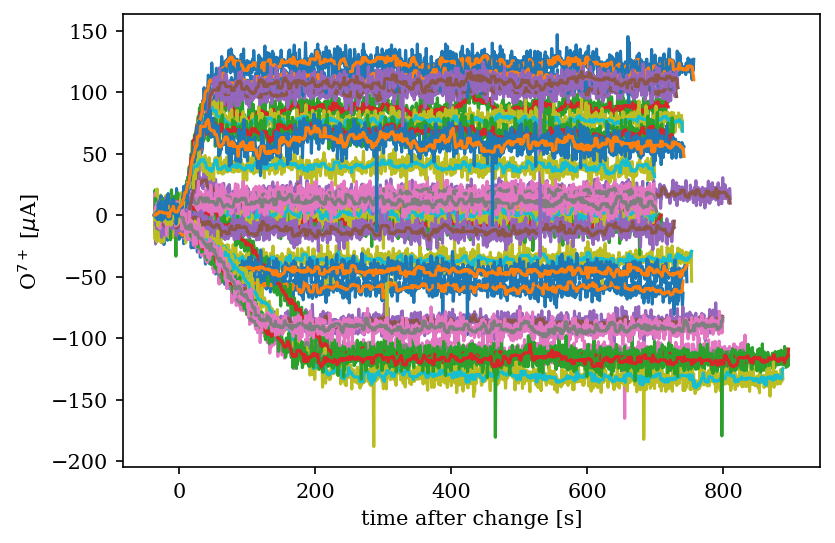. No mitigations available.

Method2:
- Terminates when the beam current when it drops below a threshold of 70% of the best so far. Feed this threshold value to the BO. 
- Problem: may interfere with the GP's ability to predict lower beam currents acurrately. Mitigation: set the threshold to a low enough value so that we do not care about beam currents in the range. 


We should use Method2 for early termination. 

Implementation:


TODO:
Characterize EIpu. Run for 50 iterations.
Run experiments on early termination.

# 2023.3.16 Notes

Questions:
1. Does the current script change the parameters in parallel?